# 1. Lesparre Equation Plots

# 2. Geometric Analysis

# 3. Incident Direction 

# 4. Angular Resolution

# 5. Acceptance

# 6. Sinographic Space

# 7. Resolution of Slices 

# 8. Movement and Rotation of Detectors: See DetectorPlacement.ipynb

- Mira Liu 12/15/19

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl

%matplotlib inline

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import math

from MuonTomographyFunctions import *

# 1. Attempts at Lesparre Plots

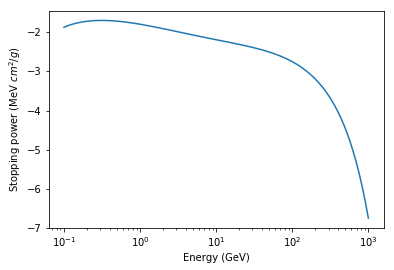

In [2]:
#Plot Equation 17 from Lesparre 2010 (Figure 2)

c0=0.2549
c1=0.0801
c2=0.0368
c3=-0.0461
c4=0.0154

energies = np.logspace(-1,3,100)

y = np.log10(energies)

stop_power = -10**(c4*(y**4)+c3*(y**3)+c2*(y**2)+c1*y+c0)

pl.plot(energies,stop_power)
pl.xscale('log')

pl.xlabel('Energy (GeV)')
pl.ylabel('Stopping power (MeV $cm^2/g$)')
pl.show()


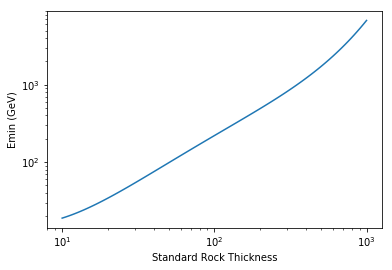

so rest energy of a muon minus the energy lost as a function of initial energy and path length is the minimum energy required to cross that opacity??


In [3]:
# Plot equation 18 from Lesparre 2010 (Figure 3)

opacity = np.logspace(1,3,100) 
E_mu = .10566
energies = np.logspace(-1,3,100)
y = np.log10(energies)
stop_power = 10**(c4*(y**4)+c3*(y**3)+c2*(y**2)+c1*y+c0)
Emin = E_mu + stop_power*opacity
pl.xscale('log')
pl.yscale('log')
pl.plot(opacity,Emin)
pl.ylabel('Emin (GeV)')
pl.xlabel('Standard Rock Thickness')
pl.show()

print('so rest energy of a muon minus the energy lost as a function of initial energy and path length is the minimum energy required to cross that opacity??')

# 2. Geometric Dimensions (from 09/30/2019 slideshow)

## dimensions of detectors: length 4.8 m, height 2.4m, depth 2m
 - 
## dimensions of 2x2 stack: length 19.2m, height 4.8m, depth 2m

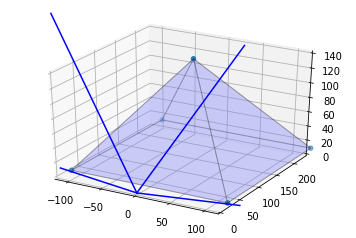

The entire pyramid is technically within the maximum angular ranges if
the detectors are located at the center and 25 m away
The stats of zenith angles (likelihood) is unknown,
so the probability of muons travelling those maximum angles is unknown.


In [4]:
# Pyramid and angle ranges 
fig = pl.figure()
ax = pl.axes(projection='3d')

#pyramid vertices
v = np.array([[-115.165,27,0],[115.165,27,0],[115.165,257.33,0],[-115.165,257.33,0],[0,142.165,138.7]])
ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])

#pyramid planes
verts = [ [v[0],v[1],v[4]], [v[0],v[3],v[4]],
 [v[2],v[1],v[4]], [v[2],v[3],v[4]], [v[0],v[1],v[2],v[3]]]

#plot 2d planes connecting vertices
collection = Poly3DCollection(verts, linewidths=1, alpha=0.2)
face_color = [0.5, 0.5, 1] # alternative: matplotlib.colors.rgb2hex([0.5, 0.5, 1])
collection.set_facecolor(face_color)
ax.add_collection3d(collection)
collection.set_edgecolor('k')


#plotting angular ranges
x = np.linspace(0,27)
az1 = x/np.cos(78.23*np.pi/180) #84.05 is max theta
az2 = -x/np.cos(78.23*np.pi/180)

pol1 = az1/np.sin(39.81*np.pi/180) #22.62 is max theta 
pol2 = -az2/np.sin(39.81*np.pi/180) #22.62 is max theta 

ax.plot(az1, x, zs=0, zdir='z',color = 'b')
ax.plot(az2, x, zs=0, zdir='z',color= 'b')
ax.plot(az1, x, pol1, zdir='z',color = 'b')
ax.plot(az2, x, pol2, zdir='z',color= 'b')

pl.ylim(0,230)
pl.xlim(-115,115)
ax.set_zlim(0,140)
#pl.savefig('/Users/Mira/Desktop/DetectorRange')
pl.show()


print('The entire pyramid is technically within the maximum angular ranges if\nthe detectors are located at the center and 25 m away')
print('The stats of zenith angles (likelihood) is unknown,\nso the probability of muons travelling those maximum angles is unknown.')



# 3. Average direction per pixel.

Doing this for ONE shipping container.

In [5]:
#building the 480 by 120 detector, with pixels of 2cm by 2cm, two detectors 200 cm apart. 

#i: pixels along x axis (horizontal)
#j: pixels along z axis (vertical)
#y: direction facing pyramid.

i = np.arange(1,960,16) #32 should be 2, this is for general visuals to minimize computing time
j = np.arange(1,240,16)

DX = np.zeros((961,241))#average direction of incident ray to hit a pixel on the second detector (after passing through first) 
DZ = np.zeros((961,241))
for Hpix in i: #for all 480 pixels along the x axis
    for Vpix in j: #for all 120 pixels along the y axis
        dx = 0. #average distance travelled in x to the first detector pixel x,y
        dz = 0. #average distance travelled in y to the first detector pixel x,y
        dy = 200.0 #distance to second detector
        for H in i: #for every pixel on the second detector x axis
            for V in j:#for every pixel on the second detector y axis
                #H,V is pixels on second detector
                #comparing to the H,V pixel on the second detector (the one it passes through first)
                dx = dx+(H-Hpix) #horizontal distance of pixel x,y to H,V (along x axis)
                dz = dz+(V-Vpix) #vertical distance of pixel x,y to H,V (along z axis)
        dx = np.sum(dx)/(len(i)*len(j))#(960*480) #AVERAGE
        dz = np.sum(dz)/(len(i)*len(j))#(960*480) #AVERAGE
        DX[Hpix,Vpix]=dx
        DZ[Hpix,Vpix]=dz

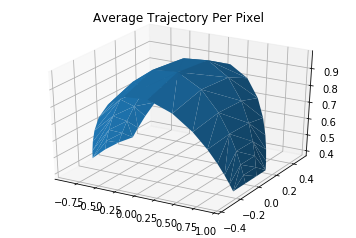

In [6]:
i = np.arange(1,960,64) #480 horizontally
j = np.arange(1,240,64) #120 vertically


Xvals = []
Yvals = []
Zvals = []
for H in i:
    for V in j:
        if DX[H][V] !=0 and DZ[H][V] !=0:
            x,y,z = unit(DX[H][V],200,DZ[H][V])
            Xvals.append(x)
            Yvals.append(y)
            Zvals.append(z)
        #print(x)
        #ax.scatter(x,y,z)

        
fig = pl.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(Xvals,Yvals,Zvals)
ax.set_title('Average Trajectory Per Pixel')
pl.show()


# 4. Angular Resolution

Similar to figure 6a) "Angular resolution $\delta\Omega$(rm,n) for each discrete direction of sight rm,n of the pair of pixels", with $\delta\Omega$ "covering all muon trajectories able to hit a given pair of pixels". 

First finding the number of pairs of pixels with relative position (i.e. how many different relative positions between pairs of pixels there are) 

In [7]:
#building the 480 by 120 detector, with pixels of 2cm by 2cm, two detectors 200 cm apart. 

i = np.arange(1,960,16) #480 horizontally
j = np.arange(1,240,16) #120 vertically

DXY = []
for Hpix in i: #for all 480 pixels along the x axis
    for Vpix in j: #for all 120 pixels along the y axis
        for H in i: #for every pixel on the second detector x axis
            for V in j:#for every pixel on the second detector y axis
                # for every combination of pixels
                dx = Hpix-H #horizontal relative displacement
                dy = Vpix-V #vertical relative displacement
                dxy = [dx,dy] #total displacement
                if dxy not in DXY:
                    DXY.append(dxy)
# creates list of the different relative dx and dy. 

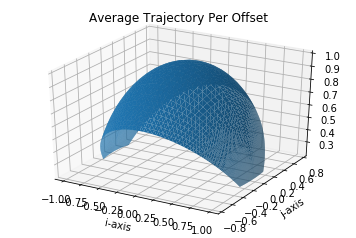

In [8]:
Xvals = []
Yvals = []
Zvals = []
for i in range(len(DXY)):
    x,y,z = unit(DXY[i][0],200,DXY[i][1])
    #thetax = math.degrees(math.atan(x/z)) # by angle
    #thetay = math.degrees(math.atan(y/z))
    #Xvals.append(thetax)
    #Yvals.append(thetay)
    Xvals.append(x) #for actual physical offset
    Yvals.append(y)
    Zvals.append(z)
fig = pl.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(Xvals,Yvals,Zvals) 
ax.set_title('Average Trajectory Per Offset')
ax.set_xlabel('i-axis')
ax.set_ylabel('j-axis')
pl.savefig('/Users/Mira/Desktop/DirectionOfSight',dpi=300)
pl.show()



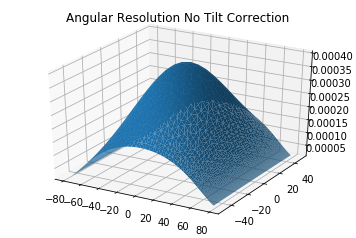

In [9]:
# now just plot the solid angle as a function of these angles. 
#solid angle is the area of a sphere covered by that solid angle. i.e. A/r^2 = 2cmx2cm / r^2 where 
#r is the distance between the two pixels ie. sqrt(dx^2 + dy^2 + dz^2)

Xvals = []
Yvals = []
SRvals = [] #solid angle
for i in range(len(DXY)):
    x=DXY[i][0]
    y=DXY[i][1]
    z=200 # distance between the detectors
    r = np.sqrt((.5*x)**2 + (.5*y)**2 + (.5*z)**2) # radius of solid angle (from center between pixels to pixel)
    A = 2*2
    Afix = A #figure out the influence of the titled solid angle
    SR = Afix/r**2
    #Xvals.append(x)
    #Yvals.append(y)
    thetax = math.degrees(math.atan(x/z)) # by angle (and the 1/2 cancels bc similar triangles)
    thetay = math.degrees(math.atan(y/z))
    Xvals.append(thetax)
    Yvals.append(thetay)
    SRvals.append(SR)
    #ax.scatter(x,y,SR)
fig = pl.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(Xvals,Yvals,SRvals)
#ax.set_xlabel('theta x')
#ax.set_ylabel('theta y')
ax.set_title('Angular Resolution No Tilt Correction')
pl.savefig('/Users/Mira/Desktop/AngularResolutionNoTilt',dpi=300)
pl.show()


#check solid angle equation (A/(D/2)^2)? (HALF the distance between the two?)
# need to include cosine theta? 
# need to multiply by the one cosine theta where theta is the angle?
# to get the influence of the tilt and the pixel no longer being perpendicular to the ray.

# can do with and without? 



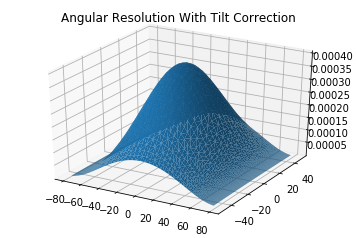

In [12]:
# now just plot the solid angle as a function of these angles. 
#solid angle is the area of a sphere covered by that solid angle. i.e. A/r^2 = 2cmx2cm / r^2 where 
#r is the distance between the two pixels ie. sqrt(dx^2 + dy^2 + dz^2)

Xvals = []
Yvals = []
SRvals = [] #solid angle
for i in range(len(DXY)):
    x=DXY[i][0]
    y=DXY[i][1]
    z=200 #(half distance between the detectors)
    r = np.sqrt((.5*x)**2 + (.5*y)**2 + (.5*z)**2)
    A = 2*2
    thetax = math.degrees(math.atan(x/z)) # by angle
    thetay = math.degrees(math.atan(y/z))
    Afix = A*math.cos(math.atan(x/z))*math.cos(math.atan(y/z))
    SR = Afix/r**2
    Xvals.append(thetax)
    Yvals.append(thetay)
    SRvals.append(SR)
    #ax.scatter(x,y,SR)
fig = pl.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(Xvals,Yvals,SRvals)
#ax.set_xlabel('theta x')
#ax.set_ylabel('theta y')
ax.set_title('Angular Resolution With Tilt Correction')
#pl.savefig('/Users/medicalphysics/Desktop/AngularResolution.png', dpi = 300)
pl.savefig('/Users/Mira/Desktop/AngularResolutionTilt', dpi=300)
pl.show()


#check solid angle equation (A/(D/2)^2)? (HALF the distance between the two?)
# need to include cosine theta? 
# need to multiply by the one cosine theta where theta is the angle?
# to get the influence of the tilt and the pixel no longer being perpendicular to the ray.

# can do with and without? 



# 5. Acceptance 

The number of pixel-pairs per direction.

In [13]:
Acc = np.zeros(len(DXY)) #all of the distances (dx,dy i.e. r_mn)
i = np.arange(1,960,16) #480 horizontally
j = np.arange(1,240,16) #120 vertically
for Hpix in i: #for all 480 pixels along the x axis
    for Vpix in j: #for all 120 pixels along the y axis
        for H in i: #for every pixel on the second detector x axis
            for V in j:#for every pixel on the second detector y axis
                # for every combination of pixels
                dx = Hpix-H #horizontal relative displacement
                dy = Vpix-V #vertical relative displacement
                dxy = [dx,dy] #total displacement
                if dxy in DXY: #So if this displacement exists
                    Acc[DXY.index(dxy)]=Acc[DXY.index(dxy)]+1 #add one count to this displacement
                    

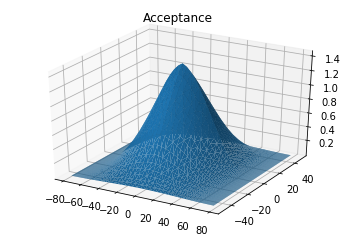

In [16]:
Xvals = []
Yvals = []
Zvals = [] #acceptance (i.e. detection area times angular resolution)
for i in range(len(DXY)):
    x=DXY[i][0]
    y=DXY[i][1]
    AccArea=np.float(Acc[i])*(2*2) #Number of pixel pairs times area of pixels
    Acceptance = AccArea * SRvals[i] #that area times the angular resolutionAccArea = 
    #Xvals.append(x)
    #Yvals.append(y)
    thetax = math.degrees(math.atan(x/z)) # by angle
    thetay = math.degrees(math.atan(y/z))
    Xvals.append(thetax)
    Yvals.append(thetay)
    Zvals.append(Acceptance)
    #ax.scatter(x,y,SR)
fig = pl.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(Xvals,Yvals,Zvals)
pl.title('Acceptance')
#pl.savefig('/Users/Mira/Desktop/Acceptance', dpi=150)

#pl.savefig('/Users/medicalphysics/Desktop/acceptance.png',dpi = 300)
pl.show()

# 6. Sinogram Space

## The formulas used here are derived on 11/12/19, with the final equation on page 3. (meaning "see notes 11/12/19")


so given a level of the detector (so j is a constant and the same on both layers of the detector)... we can know the trajectories ($\Psi=tan^{-1}(dz/dx))$ available for all combinations, and the corresponding point on the trajectory (i,j) to define a vector in the ij coordinate system. This ij coordinate system referring to the detector's internal coordinate system with the bottom left being (0,0). 

We can then translate to the xy pyramid coordinate system where the center (0,0) is located at the center of the pyramid, x is parallel to i, and y is perpendicular to the ij coordinate system (i.e. it is z in previous representations of this model). This is done so with $x = i-(960/2), y = (230.33/2 + 25)$. z (and j) are constant for this single layer of the detector.

We can also get the angle $\phi$ that generates an $\eta$ axis that is parallel to the trajectory with the equation 
$\phi = \psi - \pi/2$. 

Therefore we now have a point in xy pyramid coordinate system, and the angle $\phi$ of sinogram space. If we then translate the xy pyramid coordinate into \eta\xi sinogram coordinate system the $\xi$ value is $\xi_0$ (the intercept) because we know that \eta is parallel to the trajectory. 

Using all of this we get the following sinorgram coordinates: 
$\phi = \psi = pi/2$

$\xi_0 = xcos\phi + ysin\phi = (i-960/2)cos(\psi-pi/2) + (230.33/2 + 25)cos(\psi-pi/2)$


this is implemented in the code below:


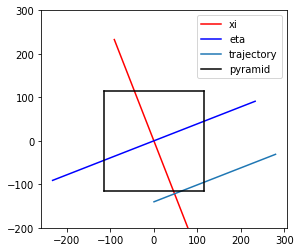

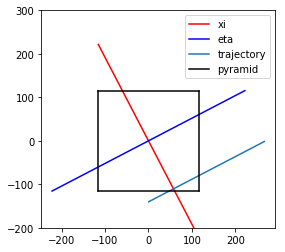

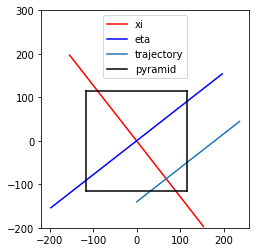

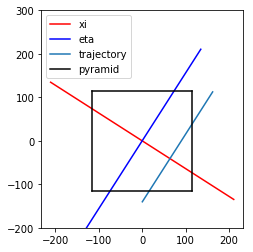

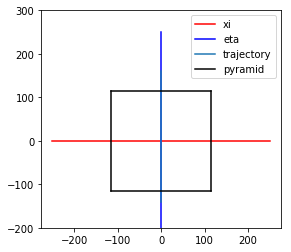

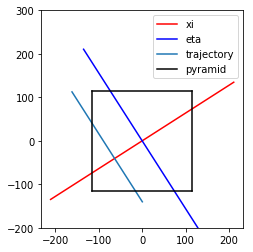

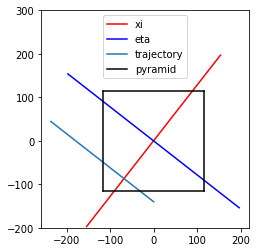

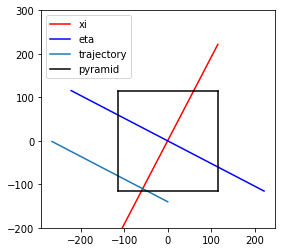

In [17]:
i = np.arange(1,960,128) #480 horizontally
if 1==1: #for all 480 pixels along the x axis
    Hpix = i[int(len(i)/2)]
    for H in i: #for every pixel on the second detector x axis
        # for every combination of pixels
        dx = Hpix-H #horizontal relative displacement
        dy = 0 #zero vertical relative displacement
        Vpix = 0 #only bottom row of j pixels
        phi_n, xi0_n,psi, x1, y1 = SinogramSpace(Hpix, Vpix,dx,dy,200)
        #print(psi)
        #print(x1,y1)
        x,y = VectorPlot(x1,y1,psi)
        #pl.scatter(x1,y1)
        xi_x, xi_y, eta_x, eta_y = RadonCoordinates(phi_n)
        pl.plot(xi_x, xi_y,color = 'red',label = 'xi')
        pl.plot(eta_x, eta_y,color = 'blue',label = 'eta')
        pl.plot(x,y,label = 'trajectory')
        pl.ylim(-200,300)
        pl.gca().set_aspect('equal', adjustable='box')
        pl.plot(p1,p2,color = 'k')
        pl.plot(p1,p3,color = 'k')
        pl.plot(p2,p1,color='k')
        pl.plot(p3,p1,color = 'k',label = 'pyramid')
        pl.legend()
        pl.show()


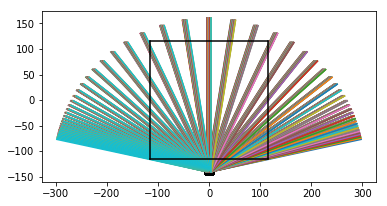

In [18]:
i = np.arange(1,960,32) #480 horizontally
#j = np.arange(1,240,64) #120 vertically
phis = []
etas = []
for Hpix in i: #for all 480 pixels along the x axis
    for H in i: #for every pixel on the second detector x axis
        # for every combination of pixels
        di = Hpix-H #horizontal relative displacement
        dj = 0 #zero vertical relative displacement
        phi_n, xi0_n,psi, x1, y1 = SinogramSpace(Hpix, Vpix,di,dj,200)
        #print(psi)
        x,y = VectorPlot(x1,y1,psi)
        pl.scatter(x1,y1,color = 'k')
        pl.plot(x,y)
pl.plot(p1,p2,color = 'k')
pl.plot(p1,p3,color = 'k')
pl.plot(p2,p1,color='k')
pl.plot(p3,p1,color = 'k')
pl.gca().set_aspect('equal', adjustable='box')
#pl.savefig('/Users/Mira/Desktop/Fan.png',dpi = 300)
pl.show()

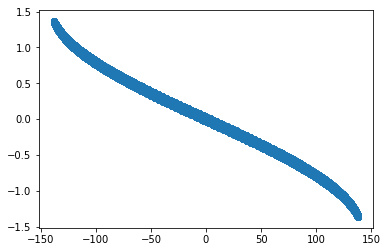

In [28]:
i = np.arange(1,960,2) #480 horizontally
j = np.arange(1,240,2) #120 vertically
phis = []
xis = []
for Hpix in i: #for all 480 pixels along the x axis
    for H in i: #for every pixel on the second detector x axis
        # for every combination of pixels
        di = Hpix-H #horizontal relative displacement (in cm)
        dj = 0 #zero vertical relative displacement
        phi_n, xi0_n,psi,x1,y1 = SinogramSpace(Hpix, Vpix, di,dj,200)
        phis.append(phi_n)
        xis.append(xi0_n)
pl.scatter(xis,phis)
#pl.xlabel('xi_0 (m)')
#pl.ylabel('phi (radians)')
pl.savefig('/Users/Mira/Desktop/SinogramSpace.png',dpi = 300)
pl.show()



pl.scatter(xis,phis)
pl.vlines(x =4.8,ymin = -1.5,ymax= 1.5)
pl.vlines(x =-4.8,ymin = -1.5,ymax= 1.5)
#pl.xlabel('xi_0 (m)')
#pl.ylabel('phi (radians)')
#pl.savefig('/Users/medicalphysics/Desktop/SinogramSpace.png',dpi = 300)
pl.show()
for i in range(len(xis)):
    if phis[i]==0.0:
        pl.scatter(xis[i],phis[i])

# 7. Resolution of Slices

This uses the bottom row of pixels of the back detector and all pixels of the front detector for simplicity. It plots the solid angle associated with each pixel pair, scaled appropriately based on the distance travelled. The distance travelled is of course which vertical slice of the pyramid is being chosen. Everything is done in the coordinate system of the pyramid.

This is from 11/20-24 (see notes from then)

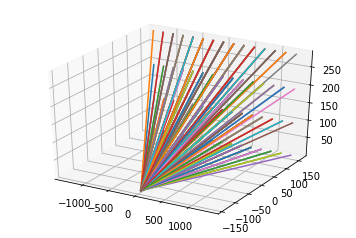

In [29]:
# plot of subsect of trajectories using 
i = np.arange(1,960,128) #480 horizontally
j = np.arange(1,240,64) #120 vertically

fig = pl.figure()
ax = pl.axes(projection='3d')

#plotting trajectories
for Hpix in i: #for all 480 pixels along the x axis
    Vpix = j[0] # only the bottom row of pixels
    for H in i: #for every pixel on the second detector x axis
        for V in j:#for every pixel on the second detector y axis
            # for every combination of pixels
            di = Hpix-H #horizontal relative displacement
            dj = V -Vpix #Vpix-V #vertical relative displacement. flipped sign for positive
            dy=200 #(half distance between the detectors)
            x,y,z = VectorPlot3D(Hpix,Vpix,di,dy,dj,300)
            ax.plot(x, y, z, zdir='z')
pl.show()

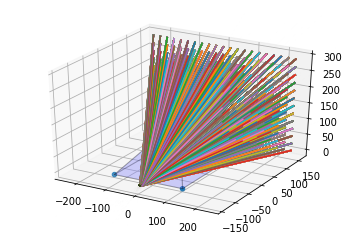

In [37]:
# Plotting pyramid and trajectories in 3d.

fig = pl.figure()
ax = pl.axes(projection='3d')



# plotting trajectories
i = np.arange(1,960,16) #480 horizontally
j = np.arange(1,240,16) #120 vertically
for Hpix in i: #for all 480 pixels along the x axis
    Vpix = j[0] # only the bottom row of pixels
    for H in i: #for every pixel on the second detector x axis
        for V in j:#for every pixel on the second detector y axis
            # for every combination of pixels
            di = Hpix-H #horizontal relative displacement
            dj = V -Vpix #Vpix-V #vertical relative displacement. flipped sign for positive
            dy=200 #(half distance between the detectors)
            x,y,z = VectorPlot3D(Hpix,Vpix,di,dy,dj,300)
            centeridx = find_nearest(y,0.0) #for center slice at y==0
            if np.abs(x[centeridx])<=115: # which do make it to the center slice
                if np.abs(z[centeridx])<=140:
                    ax.plot(x, y, z, zdir='z')

#pl.ylim(0,230)
#pl.xlim(-115,115)
#ax.set_zlim(0,140)

#pyramid vertices in pyramid coordinate system now
v = np.array([[-115.165,-115.165,0],[115.165,-115.165,0],[115.165,115.165,0],[-115.165,115.165,0],[0,0,138.7]])
ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])

#pyramid planes
verts = [ [v[0],v[1],v[4]], [v[0],v[3],v[4]],
 [v[2],v[1],v[4]], [v[2],v[3],v[4]], [v[0],v[1],v[2],v[3]]]

#plot 2d planes connecting vertices
collection = Poly3DCollection(verts, linewidths=1, alpha=0.2)
face_color = [0.5, 0.5, 1] # alternative: matplotlib.colors.rgb2hex([0.5, 0.5, 1])
collection.set_facecolor(face_color)
ax.add_collection3d(collection)
collection.set_edgecolor('k')
pl.savefig('/Users/Mira/Desktop/Trajectories')
pl.show()



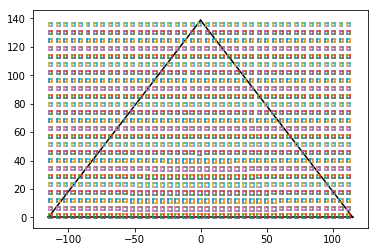

In [38]:
# now just plot the solid angle as a function of these angles. 
#solid angle is the area of a sphere covered by that solid angle. i.e. A/r^2 = 2cmx2cm / r^2 where 
#r is the distance between the two pixels ie. sqrt(dx^2 + dy^2 + dz^2)


#fig = pl.figure()
#ax = fig.gca(projection='3d')
#plotting 2d of pyramid at center slice y = 0
v1 = np.linspace(-115.165,0,50) 
v2 = np.linspace(0,115.165,50)
v3 = np.linspace(0,138.7,50)
v0 = np.zeros(50)
pl.plot(v1,v3,color = 'k')
pl.plot(v2,v3[::-1],color = 'k')
pl.plot(v1,v0,color ='k')
pl.plot(v2,v0,color = 'k')

i = np.arange(1,960,8) #480 horizontally
j = np.arange(1,240,8) #120 vertically

Xvals = []
Yvals = []
SRvals = [] #solid angle

plane = 0 #y location of slice in pyramid space. this is center slice.
DXYi = []
#for Hpix in i: #for all 480 pixels along the x axis
if 1 ==1: #to keep structure the same. 
    Hpix = 960/2 #center
    Vpix = j[0] # only the bottom row of pixels
    for H in i: #for every pixel on the second detector x axis
        for V in j:#for every pixel on the second detector y axis
            # for every combination of pixels
            di = Hpix-H #horizontal relative displacement
            dj =V-Vpix #vertical relative displacement
            dy=200 # distance between the detectors
            dr = np.sqrt((.5*di)**2 + (.5*dj)**2 + (.5*dy)**2) #half distamce between two pixels (solid angle radius), in cm
            A = 2*2
            thetax = math.degrees(math.atan(di/dy)) # by angle
            thetay = math.degrees(math.atan(dj/dy))
            Afix = A*math.cos(math.atan(di/dy))*math.cos(math.atan(dj/dy))
            dSR = Afix/dr**2 #this is the solid angle, i.e. the area covered. translate this to pixel lines.
            y1 = -((230.33/2)+25) #location of detector in pyramid space
            #propogation vector
            #r = rDistance(Hpix,Vpix,di,dy,dj,yslice)
            Scale = ((dy/2)/100)*np.abs(plane-y1) #in meters
            r = (dr/100)*Scale # in meters
            PixelArea = dSR*(r**2) #solid angle translated to meters after propogated to slice
            x,y,z = VectorPlot3D(Hpix,Vpix,di,dy,dj,300)
            centeridx = find_nearest(y,0.0) #for center slice at y==0
            if np.abs(x[centeridx])<=115:
                if np.abs(z[centeridx])<=140:
                    #ax.plot(x, y, z, zdir='z')
                    xC = x[centeridx]
                    zC = z[centeridx]
                    #pl.scatter(xC,zC)
                    x2,z2,Lines = SAPixels(xC,zC,PixelArea)
                    pl.plot(x2,Lines[2])
                    pl.plot(x2,Lines[3])
                    pl.plot(Lines[0],z2)
                    pl.plot(Lines[1],z2)
    #ax.scatter(x,y,SR)
pl.savefig('/Users/Mira/Desktop/Resolution',dpi=300)
pl.show()


    

#check solid angle equation (A/(D/2)^2)? (HALF the distance between the two?)
# need to include cosine theta? 
# need to multiply by the one cosine theta where theta is the angle?
# to get the influence of the tilt and the pixel no longer being perpendicular to the ray.

# can do with and without? 



# 8. Movement and Rotation of Detectors: See DetectorPlacement.ipynb